In [1]:
import numpy as np
import time, os, sys
import mxnet as mx
import matplotlib.pyplot as plt
import skimage
import glob
import sys
import pandas as pd
#sys.path.insert(0,'/github/cellpose/')
from cellpose import models, utils
import cv2

In [2]:
CSV_FOLDER = 'data/raw/CSV_patryk/'
TIFF_FOLDER = 'data/raw/RAW_TIFF/'
TEST_IMAGE = 'data/raw/RAW_TIFF/20072019_ND9_ND11_DIV0-1_Daam1_aTub_Phallo_10_ch_4.tif'
TEST_CSV = 'data/raw/CSV_patryk/20072019_ND9_ND11_DIV0-1_Daam1_aTub_Phallo_10_ch_4.csv'
BLOCK_ANNOTATION = 'data/raw/block_annotation2.csv'
BLOCK_SIZE = 40
TO_IGNORE = 'ND8_DIV0+2h_'

In [105]:
use_gpu = utils.use_gpu()
if use_gpu:
    device = mx.gpu()
    print("use gpu")
else:
    device = mx.cpu()

In [4]:
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
Channels_map = {
        '20072019_ND9_ND11_DIV0-1_Daam1_aTub_Phallo': [3,2],
        'ND8_DIV0+2h': [2,1],
        'ND8_DIV0+4h_20x_noConfinment': [3,1]
    }

def getChannels(name):
    for key, channels in Channels_map.items():
        if name in key:
            return channels
    print('%s not found, return default [2,3]'%name)
    return [2,3]
        
getChannels('20072019_ND9_ND11_DIV0-1_Daam1')

def getPoint(csv,position):
    x = int(float(csv['x'][position]))
    y = int(float(csv['y'][position]))
    return x,y

In [79]:
def processAll(folder_csv,folder_tiff):
    X = []
    y = []
    all_csv,all_tiff = prepareList(folder_csv,folder_tiff,TO_IGNORE)
    all_csv= all_csv[:2]
    all_tiff= all_tiff[:2]
    annotations = pd.read_csv(BLOCK_ANNOTATION, header=None)
    channels = [getChannels(tmp) for tmp in all_tiff]
    all_mask,_,_,_ = getMasks(all_tiff,channels)
#     save(all_mask,all_tiff)
    for csv, tiff, mask in zip(all_csv, all_tiff,all_mask): 
        if getAnnotation(annotations, getName(tiff)) == -1:
            print("%s not exist in annotation !"%tiff)
        else:
            Xt, yt = processImage(csv,tiff,mask,annotations)
            X = X + Xt
            y = y + yt
    return X,y
 
# def checkExistInAnnotation(tif, annotation):
#     for t in annotation[0]:
def getName(path):
    elms = path.split('/')
    return elms[len(elms)-1].split('.')[0]    
    
def save(all_mask,all_tiff):
    for i in range(len(all_tiff)):
        name = os.path.basename(all_tiff[0]).replace('.tif','.jpg')
        cv2.imwrite('data/masks/%s'%name, all_mask[i])

def processImage(csv,tiff,mask,annotations):
    print('Processing %s'%os.path.basename(tiff))
    Xt = []
    yt = []
    data = pd.read_csv(csv)
    size = data.shape[0]
    vals = getVals(data,mask)
    image = plt.imread(tiff)
    base_name = os.path.basename(tiff).split('.')[0].replace("_ch_4", "")
    for i in range(size):
        x,y = getPoint(data,i)
        if i >= len(vals):
            print("%d more than max"%i)
            continue
        val = vals[i]
        block_name = '%s_%d'%(base_name,i)
        annotation = getAnnotation(annotations,block_name)
        if annotation == -1 :
            continue
        if val > 0 :
            activated_mask = activate(mask,val)
            cropped_mask = cropImage(activated_mask,x,y,BLOCK_SIZE)
            cropped_img = cropImage(image,x,y,BLOCK_SIZE)
            Xtmp = np.dstack((testing, cropped_mask))
            
#             activated_mask = np.stack((activated_mask,)*3, axis=-1)
#             masked_image = activateImage(image, activated_mask)
            height, width = image.shape
            if(checkPosition(height, width,y,x,BLOCK_SIZE)==False):
                continue
            cropped_image = cropImage(masked_image,x,y,BLOCK_SIZE)
            Xt.append(Xtmp)
            yt.append(annotation)
    print('%s created %d images'%(os.path.basename(tiff),len(Xt)))
    return Xt, yt

def getAnnotation(annotations, name):
    for file,val in zip(annotations[0],annotations[1]):
        if name in file:
            return val
    return -1
        
def checkPosition(height,width,y,x,size):
    if x<size :
        return False
    if y<size :
        return False
    if x+size>width :
        return False
    if y+size>height:
        return False
    return True

def cropImage(image,x,y,size):
    height, width = image.shape[0],image.shape[1]
    x1 = max([0,x-size])
    y1 = max([0,y-size])
    x2 = min([width,x+size])
    y2 = min([height,y+size])
#     base=np.zeros((size*2,size*2),dtype=np.uint8)
    return image[y1:y2, x1:x2]
    
def show(img,title='Image'):
    fig2 = plt.figure(figsize = (15,15))
    ax3 = fig2.add_subplot(111)
    if len(img.shape) == 2 :
        ax3.imshow(img,cmap = 'gray', interpolation='none')
    else:
        ax3.imshow(img, interpolation='none')
        
    ax3.set_title(title)

def getPoint(data,i):
    return int(data['x'][i]),int(data['y'][i])

def activate(array,value):
    return (array == value) * 1

def activateImage(image,mask):
    return (mask == 1)*image

def getVals(data,mask):
    vals = []
    not_found = 0
    duplicate = 0
    for i in range(data.shape[0]):
        x,y = getPoint(data,i)
        val = mask[y][x]
        if val == 0 :
            not_found = not_found +1
            print("%d- %d Not found!"%(i,val))
        else:
            if val in vals:
                duplicate = duplicate +1
                print("%d- %d already exists!"%(i,val))
        vals.append(val)
    print("not found: %d"%not_found)
    print("duplicate: %d"%duplicate)
    return vals,not_found,duplicate

    
def prepareList(folder_csv,folder_tiff,to_ignore):
    all_csv = []
    all_tiff = []
    list_tiff = os.listdir(folder_tiff)
    
    for tiff in list_tiff:
        tiff_path = os.path.join(folder_tiff,tiff)
        csv = "%s.csv"%tiff.split('.')[0]
        csv_path = os.path.join(folder_csv,csv)
        if not os.path.exists(tiff_path):
            print('%s not exist'%tiff)
            continue
        if not os.path.exists(csv_path):
            print('%s not exist'%csv)
            continue
        if to_ignore in tiff :
            print('%s to ignore'%csv)
            continue
        all_csv.append(csv_path)
        all_tiff.append(tiff_path)
    return all_csv,all_tiff

def getMasks(list_tiff,channels):
    print('Detecting masks ..')
    model = models.Cellpose(device, model_type='cyto')
    imgs = [plt.imread(f) for f in list_tiff]
    nimg = len(imgs)
#     channels = [channel for i in range(len(list_tiff))]
    masks, flows, styles, diams = model.eval(imgs, rescale=None, channels=channels)
    print('masks detected.')
    return masks, flows, styles, diams



In [7]:
def getMainTiffFromBlock(name):
    elms = name.split('/')
    fileName =elms[len(elms)-1]
    fileName = fileName.split('.')[0]
    elms = fileName.split('_')
    nb = elms[len(elms)-1]
    elms = elms[:len(elms)-1]
    return '_'.join(elms),int(nb)

def loadAnnotation(path):
    annotation = pd.read_csv(path, header=None)
    annotation = annotation.sort_values(by=[0])
    annotation = annotation.reset_index(drop=True)
    return annotation

def processTif(path,name):
    img = plt.imread(path)
    channels = [getChannels(name)]
    mask,_,_,_ = getMasks([path],channels)
    return img, mask[0]

In [106]:
name = '20072019_ND9_ND11_DIV0-1_Daam1_aTub_Phallo_10'
img = plt.imread(TEST_IMAGE)

In [17]:
img,mask = processTif(TEST_IMAGE,name)

20072019_ND9_ND11_DIV0-1_Daam1_aTub_Phallo_10 not found, return default [2,3]
Detecting masks ..
masks detected.


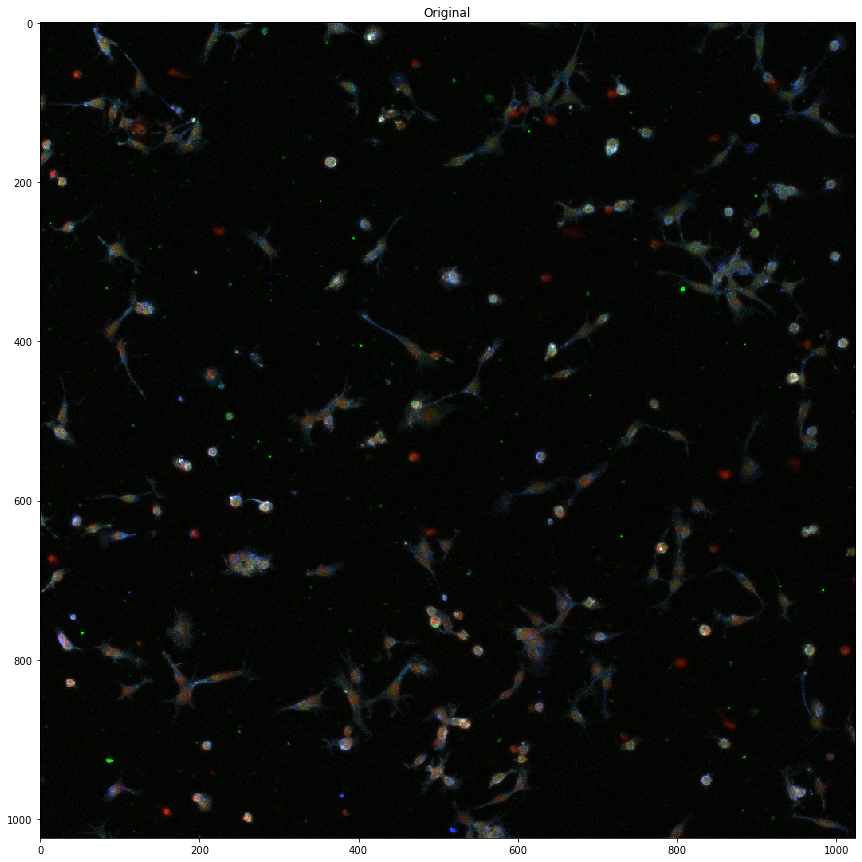

In [107]:
show(img,"Original")

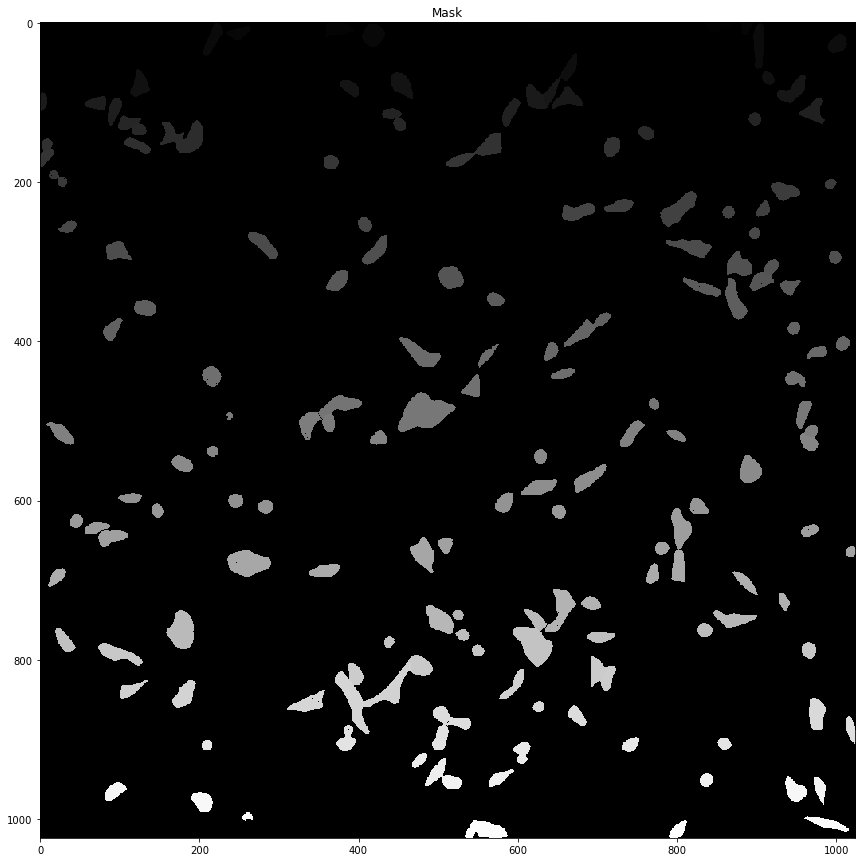

In [108]:
show(mask,"Mask")

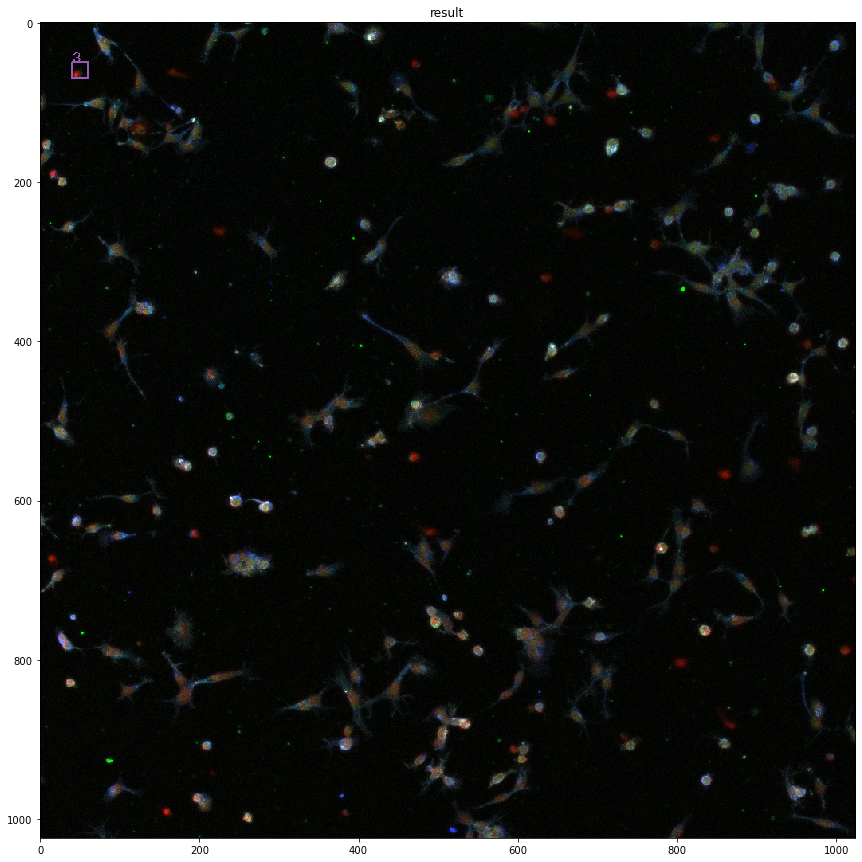

In [114]:
Colors_map = {
        '0': (231, 76, 60),
        '1': (46, 204, 113),
        '2': (52, 152, 219),
        '3': (155, 89, 182),
        '4': (241, 196, 15),
        '5': (127, 140, 141)
    }

def getColor(name):
    for key, color in Colors_map.items():
        if name in key:
            return color
    print('%s not found, return default (231, 76, 60)'%name)
    return (231, 76, 60)

def setBox(img, val,x1,y1):
    text = str(val)
    color = getColor(text)
    if val == 5:
        image = cv2.rectangle(img, (x1-10, y1-10), (x1+10, y1+10), color, 1)
    else:
        image = cv2.rectangle(img, (x1-10, y1-10), (x1+10, y1+10), color, 2)
        cv2.putText(image, text, (x1-10, y1-10), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.9, color, 1)
    return image
# x,y,w,h = cv2.boundingRect(contour)

image = setBox(img.copy(),"3",50,60)
show(image,"result")

### Process
Go throw annotation and load images and generate 4d images : 3d + mask 80*80

In [55]:
Xt = []
Mt = []
Yt = []
annotated = []
skipped = 0
i = 0

In [52]:
annotation = loadAnnotation(BLOCK_ANNOTATION)
fileName,n = getMainTiffFromBlock(annotation[0][0])
print(currentFile)
currentFile = fileName
tifFile = TIFF_FOLDER + fileName+'.tif'
img, mask = processTif(tifFile,currentFile)
csvFile = CSV_FOLDER+fileName+'.csv'
csv = pd.read_csv(csvFile, header=0)

20072019_ND9_ND11_DIV0-1_Daam1_aTub_Phallo_10_ch_4
20072019_ND9_ND11_DIV0-1_Daam1_aTub_Phallo_10_ch_4 not found, return default [2,3]
Detecting masks ..
masks detected.


In [56]:
for ann,ytp in zip(annotation[0],annotation[1]):
     
    fileName,n = getMainTiffFromBlock(ann)
    annotated.append(n)
    if fileName != currentFile:
        if skipped > 0 :
            print("Total skipped %d/%d"%(skipped,i))
        print("Processing %s"%fileName)
        break
        i = 0
        if TO_IGNORE in fileName:
            continue
        
        
    x,y = getPoint(csv,n)
#     print("x= %d , y= %d %s"%(x,y,mask.shape))
#     if checkPosition(mask.shape[0],mask.shape[1],y,x,BLOCK_SIZE) == False:
#         skipped = skipped + 1
#         continue
        
    val = mask[y][x]
    activated_mask = activate(mask,val)
    cropped_mask = cropImage(activated_mask,x,y,BLOCK_SIZE)
    cropped_image = cropImage(img,x,y,BLOCK_SIZE)
    Xt.append(cropped_image)
    Yt.append(ytp)
    Mt.append(cropped_mask)
#     cropped_image = cropped_image / 255.
#     Xtmp = np.dstack((cropped_image, cropped_mask))
    

    i = i+1
    
#     print(csv)
#     print(x)
#     break

Processing 20072019_ND9_ND11_DIV0-1_Daam1_aTub_Phallo_11_ch_4


In [61]:
print("Xt: %d"%len(Xt))
print("Mt: %d"%len(Mt))
print("Yt: %d"%len(Yt))
print("annotated: %d"%len(annotated))
print("skipped: %d"%skipped)
print("i: %d"%i)

Xt: 55
Mt: 55
Yt: 55
annotated: 56
skipped: 0
i: 55


(80, 80, 3)
4
(80, 80)


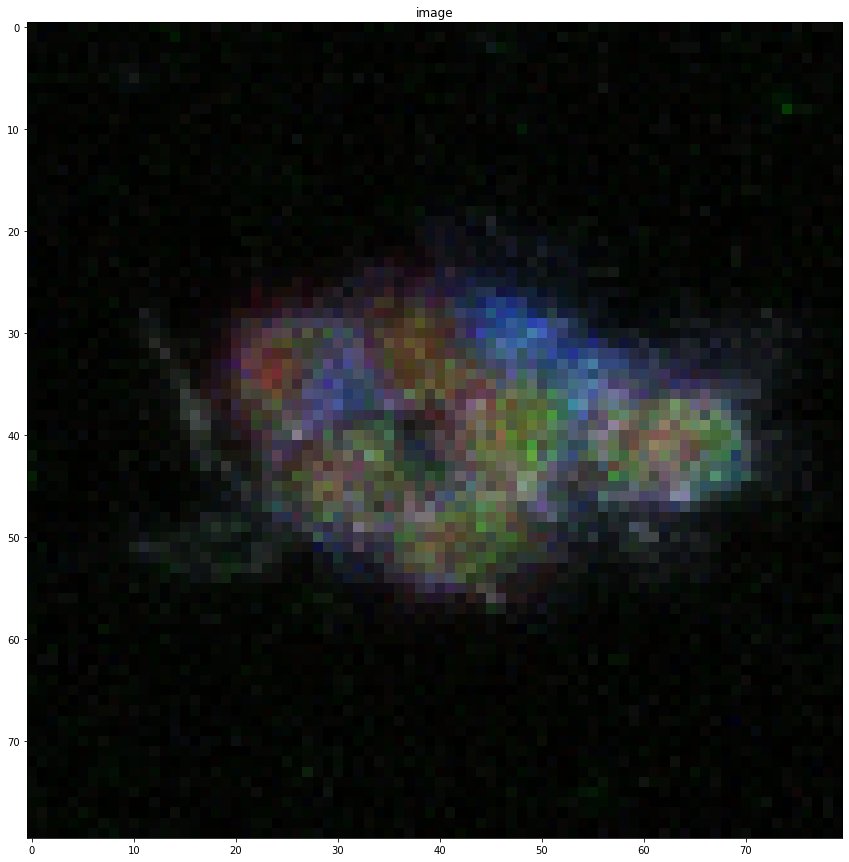

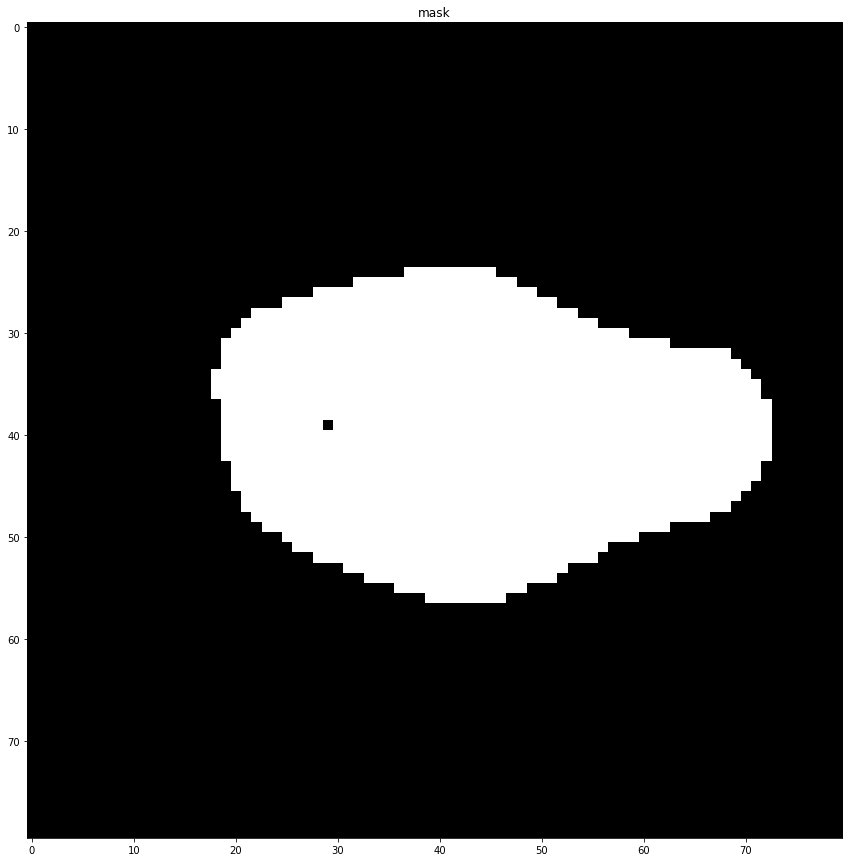

In [101]:
num = 15
print(Xt[num].shape)
print(Yt[num])
print(Mt[num].shape)
show(Xt[num],'image')
show(Mt[num],'mask')

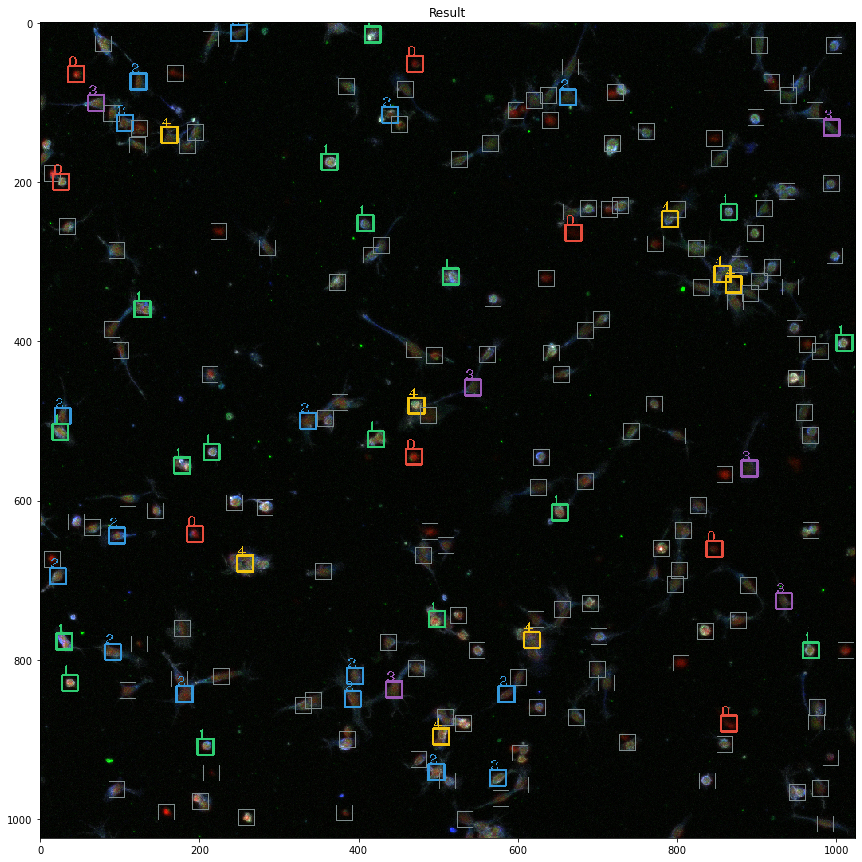

In [115]:
import random
result = img.copy()
value = 0
for i,(x,y) in enumerate(zip(csv['x'],csv['y'])):
    if i in annotated:
        index = annotated.index(i)
        value = Yt[index]
    else:
        value = 5
    result = setBox(result,value,int(x),int(y))
#         print('%d annotated!'%i)
        
#     image = setBox(img.copy(),"3",50,60)

fig2 = plt.figure(figsize = (15,15))
ax3 = fig2.add_subplot(111)
ax3.imshow(result, interpolation='none')
ax3.set_title("Result")
plt.savefig('foo.png')

###  Archive

In [ ]:
# for idx in range(nimg):
#     img = transforms.reshape(imgs[idx], channels[idx])
#     img = plot.rgb_image(img)
#     maski = masks[idx]
#     flowi = flows[idx][0]

#     fig = plt.figure(figsize=(12,3))
#     # can save images (set save_dir=None if not)
#     plot.show_segmentation(fig, img, maski, flowi)
#     plt.tight_layout()
#     plt.show()

In [ ]:
# show(imgs[0],'Original')
# show(masks[0],'Mask')
# show(flows[0][0],'Flow')

In [ ]:
# activated_mask = activate(masks[0],110)
# print(activated_mask.max())
# activated_mask = np.stack((activated_mask,)*3, axis=-1)
# print(activated_mask.shape)
# show(activated_mask,'Mask')

In [ ]:
# number_segments = masks[0].max()
# # number_segments
# for i in range(1,20):
#     x = activate(masks[0],i)
#     stacked_img = np.stack((x,)*3, axis=-1)
#     dst = activateImage(image, stacked_img)
#     show(dst,str(i))

In [50]:
# X,y = processAll(CSV_FOLDER,TIFF_FOLDER)
# print(X.shape)
# print(y.shape)

In [51]:
# import cv2
# image = imgs[0]
# dst = activateImage(image, stacked_img)
# show(dst,'Mask')

In [53]:
# annotation = pd.read_csv(BLOCK_ANNOTATION, header=None)

In [54]:
# print(point)
# for i in range(csv.shape[0]):
#     x,y = getPoint(csv,i)
#     val = mask[y][x]
#     activated_mask = activate(mask,val)
# #     show(activated_mask,"cropped")
#     cropped_mask = cropImage(activated_mask,x,y,BLOCK_SIZE)
#     show(cropped_mask,"cropped")
#     cropped_image = cropImage(img,x,y,BLOCK_SIZE)
#     show(cropped_image,"cropped")
#     np.dstack((testing, cropped_mask)).shape